In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from IPython.display import clear_output
import itertools
import time
import os

In [2]:
"""
imputation_select = {"rf","mean","mice"}
prevalence_rate = {0.001,0.005,0.01}
"""

imputation_select = "rf"
prevalence_rate = 0.01

In [3]:
#csvのパスを設定
csv_path = "/Users/ishigurofutoshi/lab_materials/data/integrated_route.csv"

missing_rate_path = "/Users/ishigurofutoshi/lab_materials/data/missing_rate_"+str(prevalence_rate)+".xlsx"

output_path = "/Users/ishigurofutoshi/lab_materials/test/"+imputation_select
fig_output_path = output_path+"/fig/"+str(prevalence_rate)
excel_output_path = output_path+"/excel"

In [4]:
df = pd.read_csv(csv_path,index_col=0)
# Slice [start:stop:step], starting from index 5 take every 6th record.
#df = df[5::6]
df = df.dropna(axis=1)
date_time = pd.to_datetime(df.pop('5 Minutes'), format='%Y.%m.%d %H:%M').reset_index(drop=True)

In [5]:
#n_input = 10
n_min_ahead = 6
window_len = 24

plot_start = 900
plot_range = 100

In [6]:
df = df.reset_index(drop=True)

In [7]:
missing_rate_df = pd.read_excel(missing_rate_path)

### 標準化

In [8]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
#train_df = df[0:int(n*0.9)]
#val_df = df[int(n*0.7):int(n*0.9)]
#test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [9]:
df_mean = df.mean()
df_std = df.std()

df = (df - df_mean) / df_std
#val_df = (val_df - train_mean) / train_std
#test_df = (test_df - train_mean) / train_std

In [10]:
def select_index(target):
    df_neighber = pd.read_excel("/Users/ishigurofutoshi/lab_materials/data/neighber_link_matrix.xlsx",index_col=0)
    index = []
    for id in df_neighber.index:
        if df_neighber.loc[id,float(target)] == 1:
            index.append(str(id))
    n_input = len(index)
    return index,n_input

def select_index(df,target):

    corrs = []
    for c in df.columns:
        corr = np.corrcoef(df[target],df[c])[0,1]
        corrs.append(corr)
    corrs = np.array(corrs)
    
    #重要度の上位を出力
    idx_corrs = np.argsort(np.abs(corrs))[::-1]
    top_cols_corrs,top_importances_corrs = df.columns.values[idx_corrs][:n_input],corrs[idx_corrs][:n_input]
    print(top_cols_corrs,top_importances_corrs)
    
    #targetのインデックスを追加
    if not target in top_cols_corrs:
        top_cols_corrs = np.append(top_cols_corrs,[target])
    
    top_cols_select = top_cols_corrs
    
    return top_cols_select


In [11]:
def init_df(target,imputation_select):
    select_features,n_input = select_index(target)

    df_for_target = df.loc[:,select_features]
    
    labels_df_time = pd.concat((date_time,df_for_target.loc[:,target]),axis=1,sort=False)
    inputs_df_time = pd.concat((date_time,df_for_target.loc[:,select_features]),axis=1,sort=False)
    
    for t in range(24):
        for i in labels_df_time.iloc[:int(80100*0.9)].loc[labels_df_time["5 Minutes"].dt.hour==t].sample(frac=missing_rate_df[target][t]).index:
            labels_df_time.loc[i,target] = np.nan
        for route in select_features:
            for i in inputs_df_time.loc[inputs_df_time["5 Minutes"].dt.hour==t].sample(frac=missing_rate_df[route][t]).index:
                inputs_df_time.loc[i,route] = np.nan
                
    inputs_df = inputs_df_time.drop(["5 Minutes"],axis=1)
    labels_df = labels_df_time.drop(["5 Minutes"],axis=1)

    if imputation_select=="rf":
        #RandomForest imputation
        inputs_df,labels_df = random_forest_imputation(inputs_df,labels_df,select_features)
    elif imputation_select=="mean":
        #mean imputation
        inputs_df,labels_df = mean_imputation(inputs_df,labels_df)
        
    elif imputation_select=="mice":
        #MICE
        inputs_df,labels_df = mice_imputation(inputs_df,labels_df,select_features)
    
    return inputs_df,labels_df,inputs_df_time,labels_df_time,select_features,n_input

In [12]:
def random_forest_imputation(inputs_df,labels_df,select_features):
    rf = RandomForestRegressor(n_estimators=10, n_jobs=-1)
    imp = IterativeImputer(random_state=0,estimator=rf)
    inputs_df = pd.DataFrame(imp.fit_transform(inputs_df),columns=select_features)
    labels_df = pd.DataFrame(imp.fit_transform(labels_df))
    return inputs_df,labels_df

In [13]:
def mean_imputation(inputs_df,labels_df):
    inputs_df = inputs_df.fillna(inputs_df.mean())
    labels_df = labels_df.fillna(labels_df.mean())
    return inputs_df,labels_df

In [14]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

def mice_imputation(inputs_df,labels_df,select_features):
    imp = IterativeImputer(max_iter=10, random_state=0, sample_posterior=True,tol=0.0001)
    inputs_df = pd.DataFrame(imp.fit_transform(inputs_df),columns=select_features)
    labels_df = pd.DataFrame(imp.fit_transform(labels_df))
    return inputs_df,labels_df

In [15]:
def show_imputation(target,inputs_df,select_features):
    original = df[target].values
    imputation = inputs_df[target].values
    
    plt.figure(figsize=(15,10))

    plt.scatter(range(30),original[:30],color="blue")
    plt.scatter(range(30),imputation[:30],color="red")
    
    dirname = fig_output_path+"/imputation/"
    os.makedirs(dirname, exist_ok=True)
    plt.savefig(dirname+target+".png")

    plt.show()

In [16]:
def make_dataset(labels_df,inputs_df,window_len):
    labels, inputs = [], []
    for i in range(len(labels_df)-(window_len+n_min_ahead-1)):
        labels.append(labels_df.iloc[i+window_len+n_min_ahead-1])
        inputs.append(inputs_df.iloc[i:i+window_len])
    re_labels = np.array(labels).reshape(len(labels),1)
    re_inputs = np.array(inputs).reshape(len(inputs),window_len,n_input)
    
    return re_labels,re_inputs

In [17]:
def show_prediction(test_y,predicted):
    plt.figure(figsize=(15,10))

    plt.plot(test_y[plot_start:plot_start+plot_range],color="blue")
    plt.plot(predicted[plot_start:plot_start+plot_range],color="orange")
    
    dirname = fig_output_path+"/prediction/"
    os.makedirs(dirname, exist_ok=True)
    plt.savefig(dirname+target+".png")

In [18]:
def show_missing_position(test_y,labels_df_time,select_features):
    NaN_position = [np.nan for i in range(len(test_y))]
    measured_position = [np.nan for i in range(len(test_y))]
    tmp = list(itertools.chain.from_iterable(test_y))

    for i in range(len(test_y)):
        if np.isnan(labels_df_time.iloc[i,1]):
            NaN_position[i] = tmp[i]
        else:
            measured_position[i] = tmp[i]
    NaN_mask = [[0 for i in range(len(select_features))] for j in range(len(test_x[plot_start:plot_start+plot_range,:]))]

    c_num = 0
    for c in select_features:
        for i in range(len(test_x[plot_start:plot_start+plot_range,:])):
            if np.isnan(inputs_df_time[c].iloc[int(n*0.9)+plot_start+i,]):
                NaN_mask[i][c_num] = 1
        c_num += 1

    NaN_mask = np.array(NaN_mask)
    NaN_mask_df = pd.DataFrame(data=NaN_mask.T,index=select_features,columns=inputs_df_time["5 Minutes"].iloc[int(n*0.9)+plot_start:int(n*0.9)+plot_start+plot_range,].dt.strftime("%Y/%m/%d-%H:%M"))
    
    plt.figure(figsize=(15,10))
    sns.set(rc={"figure.figsize":(15,3)})
    sns.heatmap(NaN_mask_df,cmap="Reds",cbar=False)
    
    dirname = fig_output_path+"/missing_position/"
    os.makedirs(dirname, exist_ok=True)
    plt.savefig(dirname+target+".png")

In [19]:
def evaluation(evaluation_list,training_time):
    performance = model.evaluate(test_x,test_y, verbose=0)
    evaluation_list.append([performance,training_time])
    
    return evaluation_list

/Users/ishigurofutoshi/opt/anaconda3/envs/pems/lib/python3.7/site-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


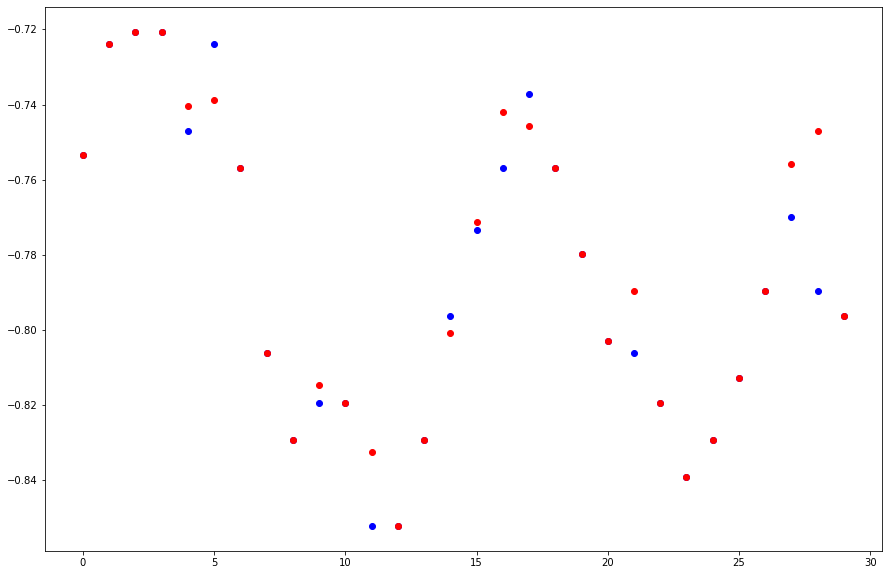

2022-08-13 21:22:07.104259: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
217/217 [==============================] - ETA: 0s - loss: 0.1560WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fabdb9798c0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full 

/Users/ishigurofutoshi/opt/anaconda3/envs/pems/lib/python3.7/site-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


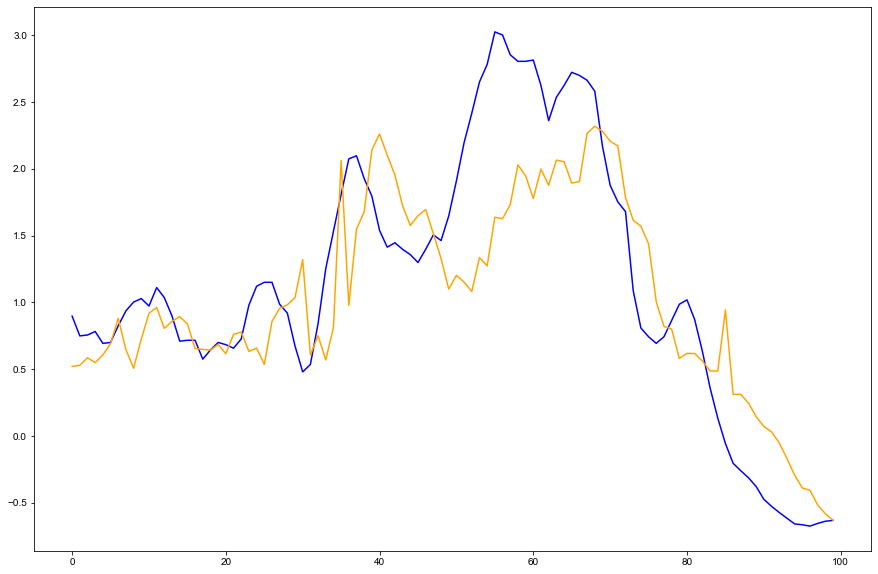

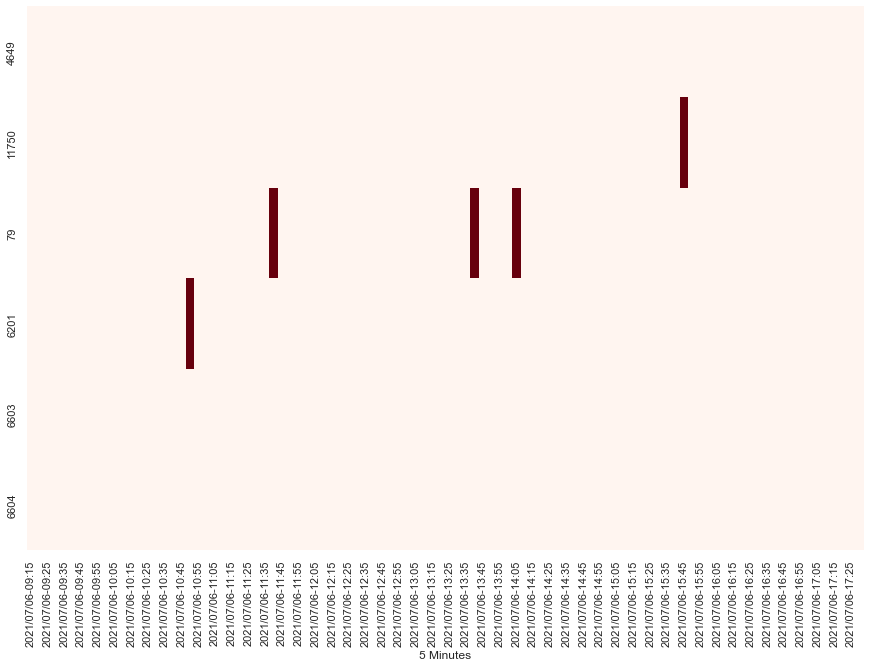

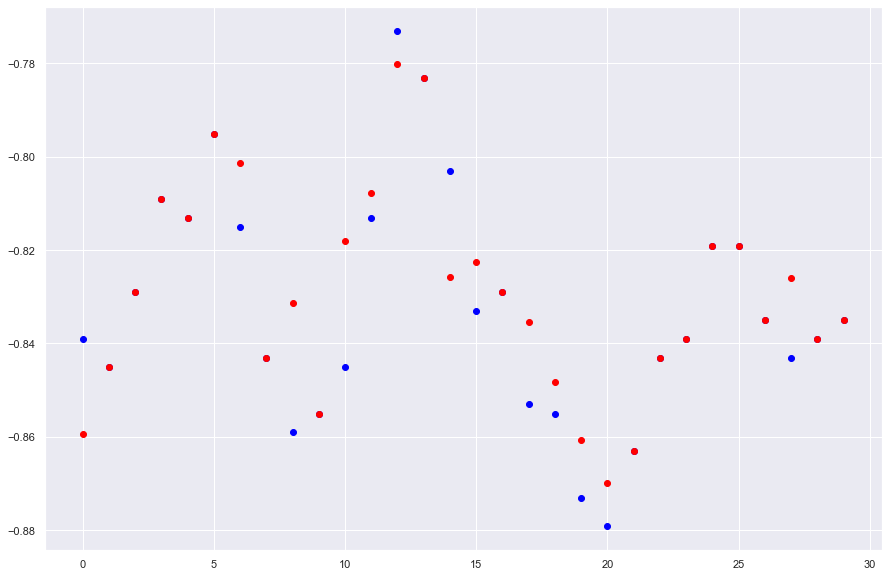

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
217/217 [==============================] - ETA: 0s - loss: 0.1738WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fabca39e290> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full 

/Users/ishigurofutoshi/opt/anaconda3/envs/pems/lib/python3.7/site-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


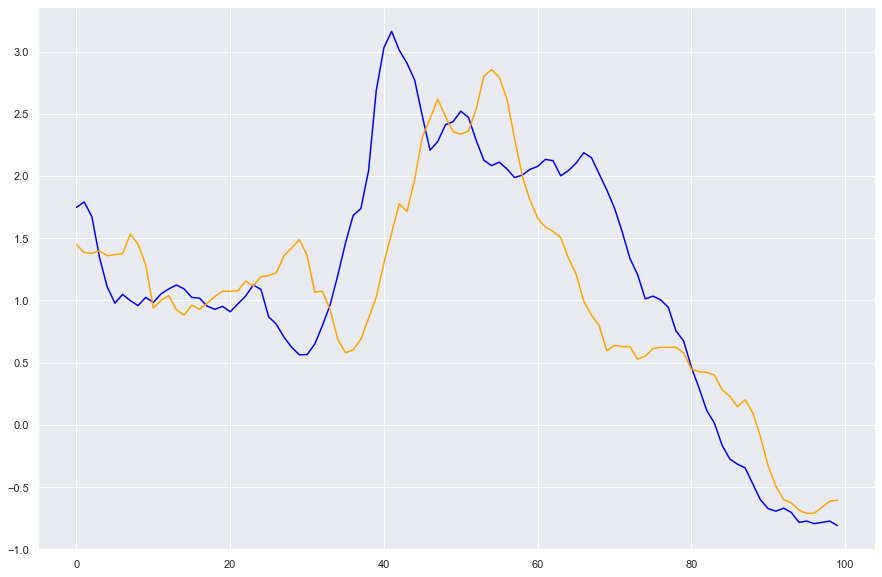

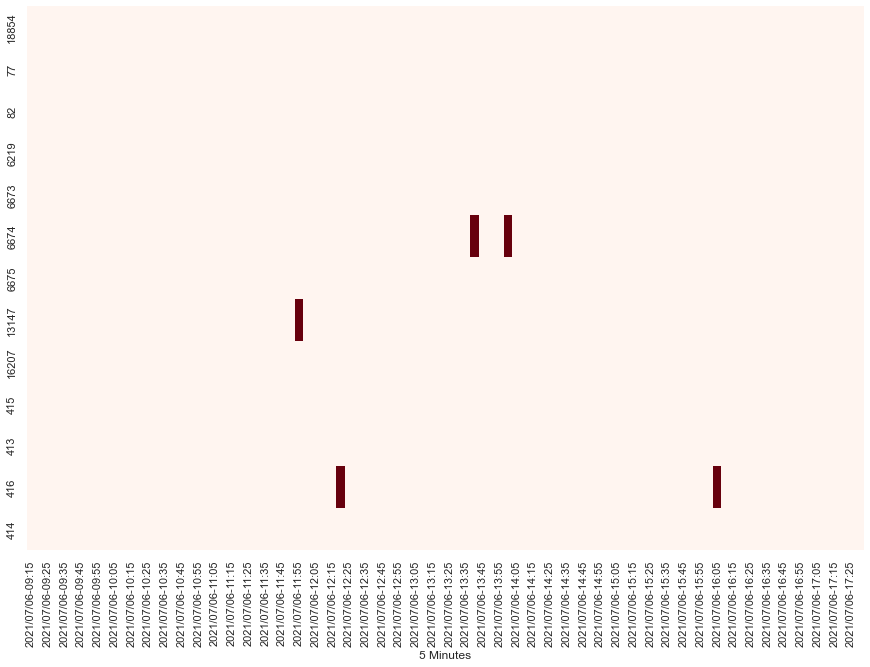

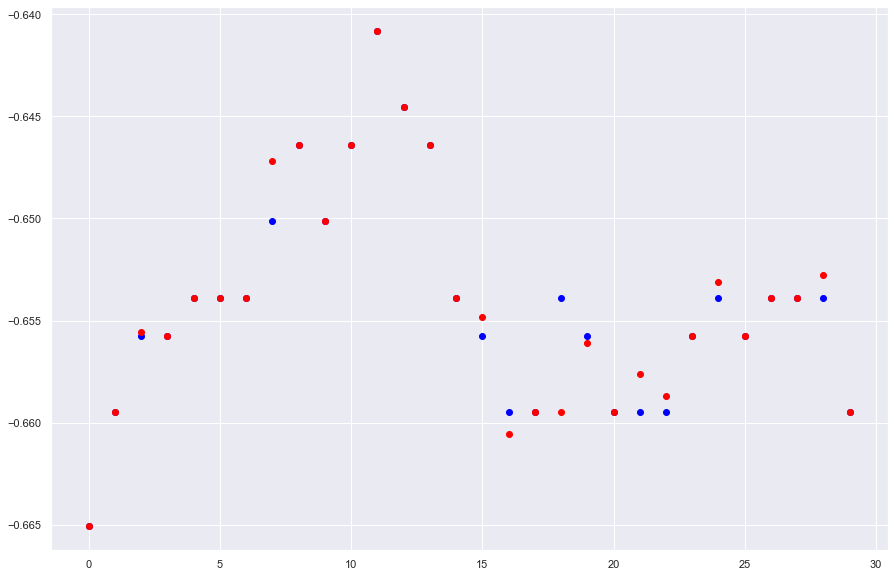

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
217/217 [==============================] - ETA: 0s - loss: 0.0782WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fabdb8f8d40> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full 

/Users/ishigurofutoshi/opt/anaconda3/envs/pems/lib/python3.7/site-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


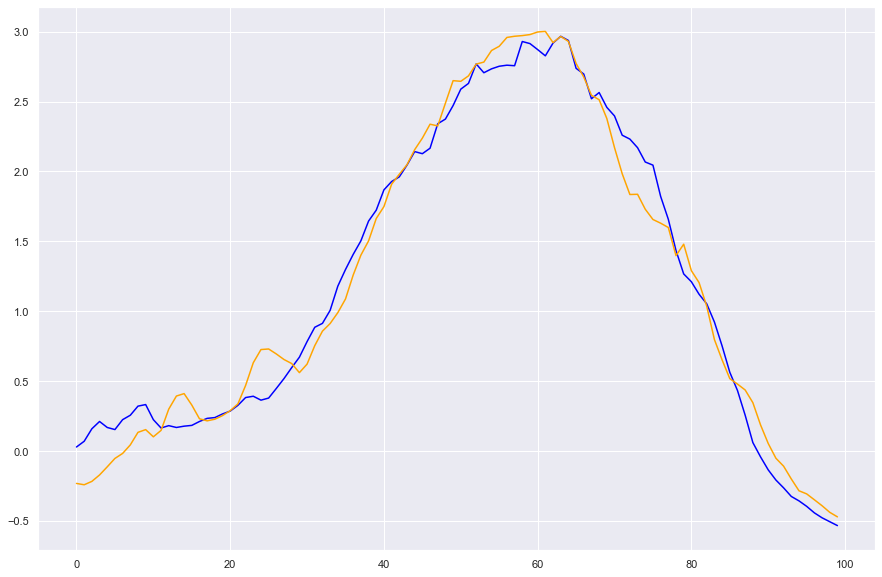

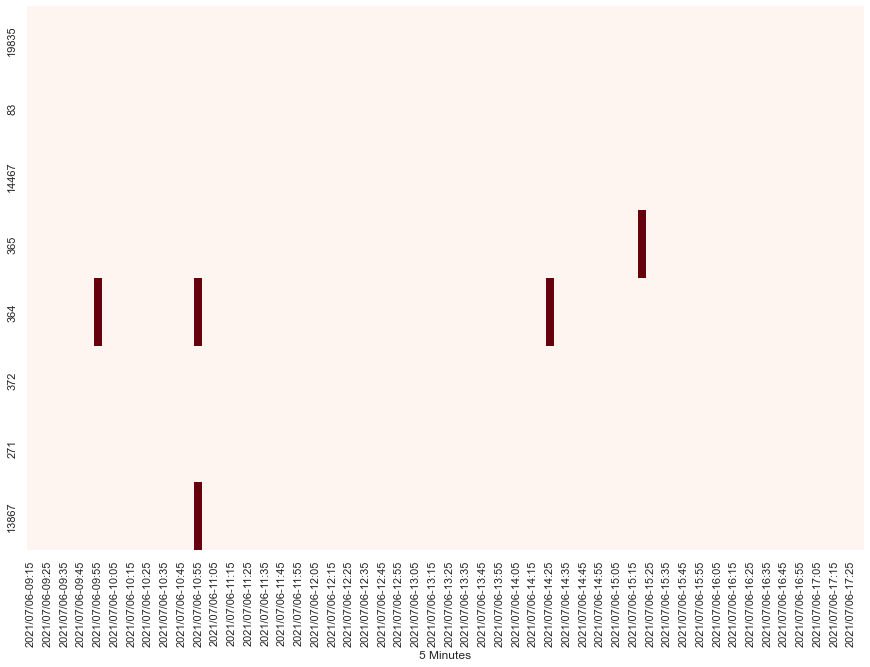

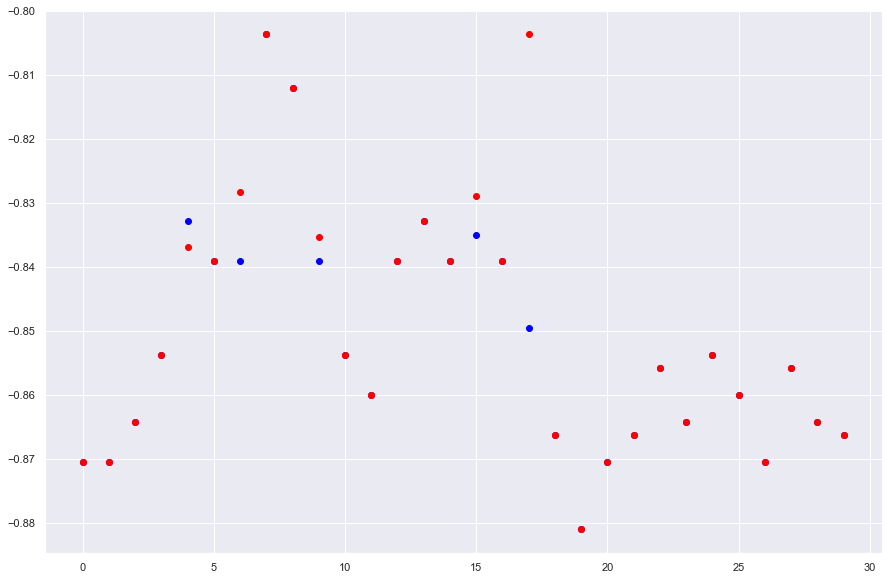

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
217/217 [==============================] - ETA: 0s - loss: 0.1256WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fabca39eef0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full 

/Users/ishigurofutoshi/opt/anaconda3/envs/pems/lib/python3.7/site-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


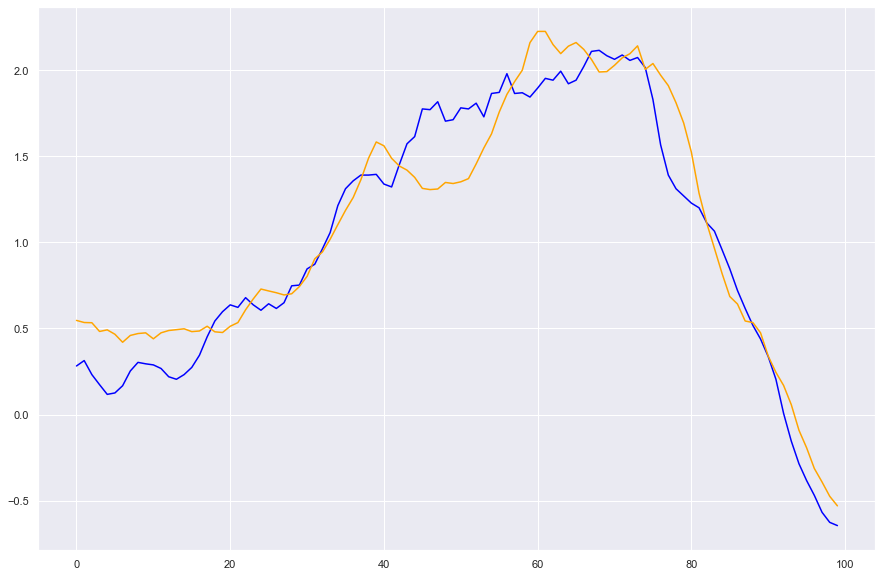

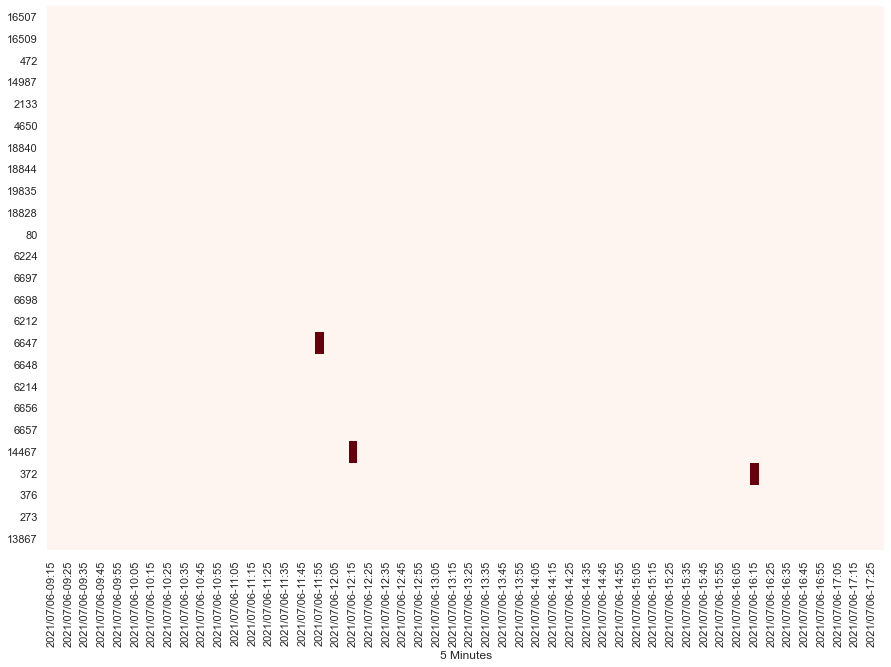

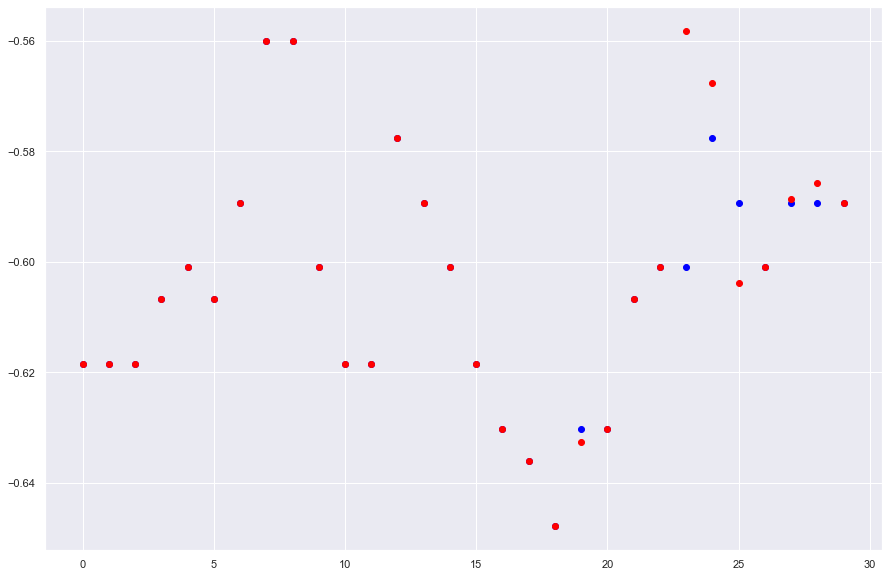

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
217/217 [==============================] - ETA: 0s - loss: 0.1645WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7faafc41f830> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full 

/Users/ishigurofutoshi/opt/anaconda3/envs/pems/lib/python3.7/site-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


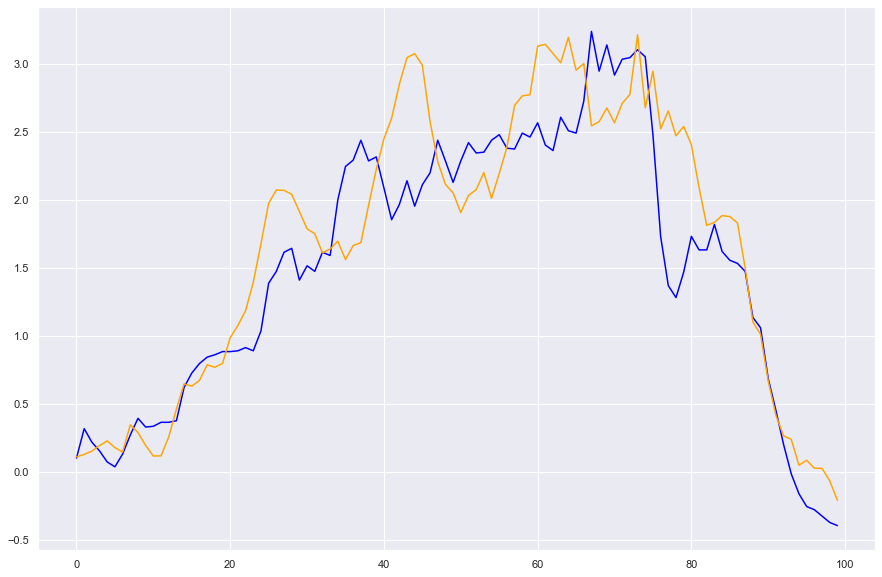

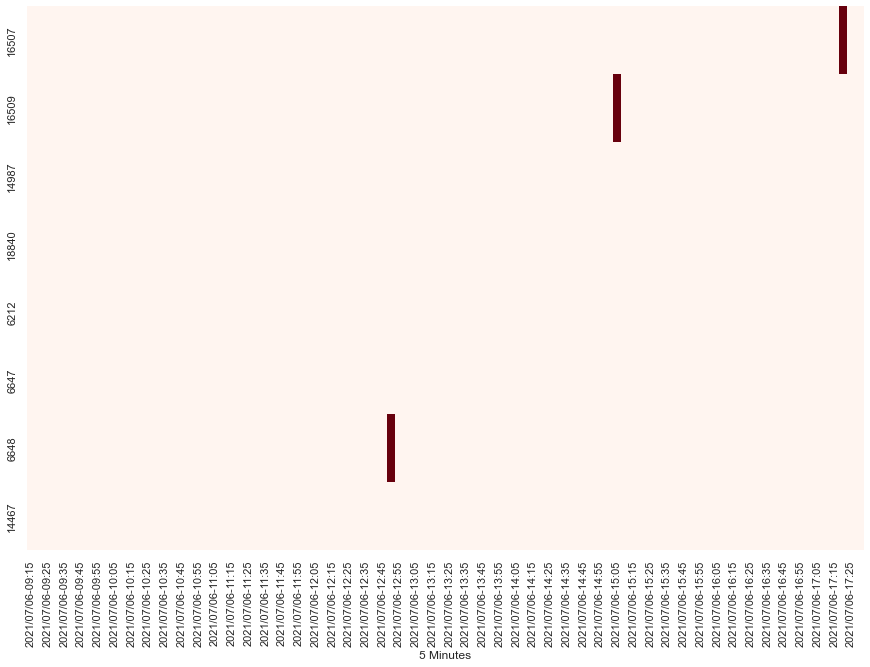

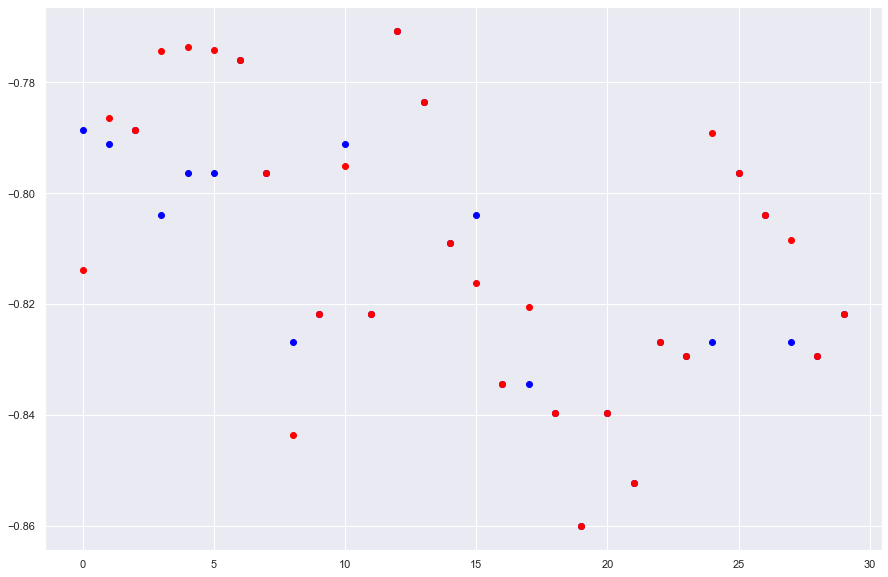

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
217/217 [==============================] - ETA: 0s - loss: 0.1827WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fabca30f170> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full 

KeyboardInterrupt: 

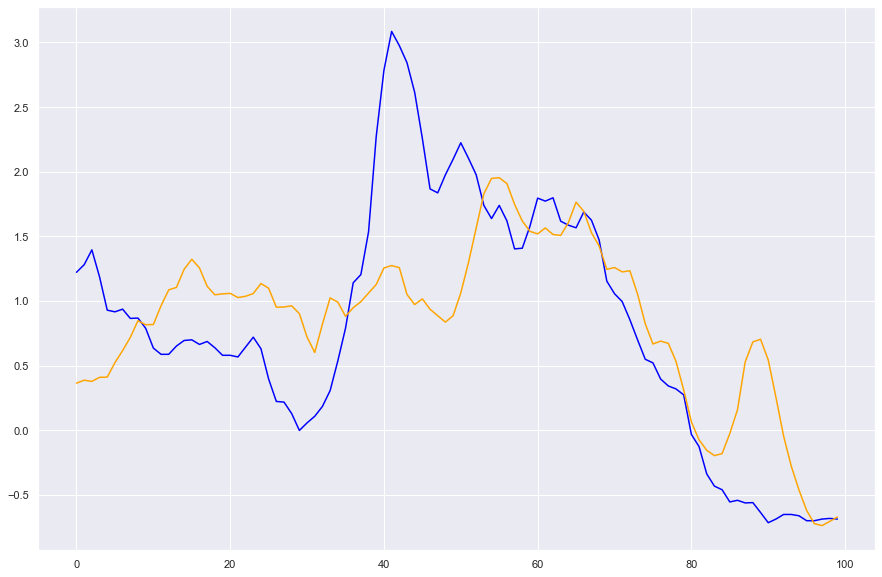

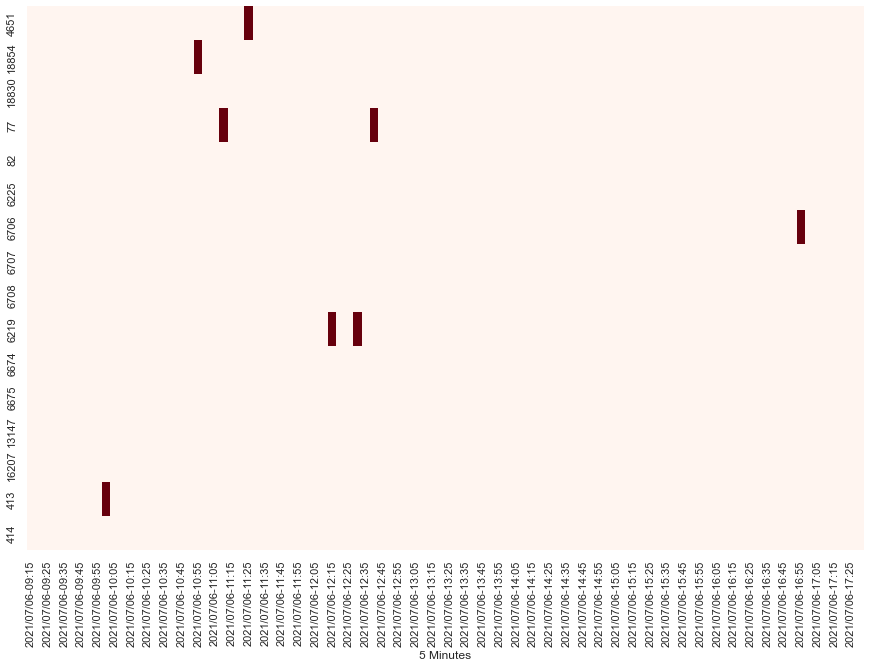

In [20]:
evaluation_list = []
for target in df.columns:

    index_target = df.columns.get_loc(target)
    
    #DataFrameの作成（欠損作成＆補完）

    inputs_df,labels_df,inputs_df_time,labels_df_time,select_features,n_input = init_df(target,imputation_select)
    
    #単一値補完の描画
    show_imputation(target,inputs_df,select_features)
    
    labels_ds, inputs_ds = make_dataset(labels_df,inputs_df,window_len)
    
    n = len(inputs_ds)
    train_x, test_x = inputs_ds[:int(n*0.9)],inputs_ds[int(n*0.9):] 
    train_y, test_y = labels_ds[:int(n*0.9)],labels_ds[int(n*0.9):]
    
    # モデル構築
    # 1つの学習データのwindowサイズ
    length_of_sequence = inputs_ds.shape[1] 
    in_out_neurons = 1
    n_hidden = 300

    model = Sequential()
    #model.add(LSTM(n_hidden, batch_input_shape=(None, length_of_sequence, n_input), return_sequences=True))
    #model.add(LSTM(n_hidden, batch_input_shape=(None, length_of_sequence, n_input), return_sequences=True))
    model.add(LSTM(n_hidden, batch_input_shape=(None, length_of_sequence, n_input), return_sequences=False))
    model.add(Dense(in_out_neurons))
    #model.add(Activation("linear"))
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss="mean_squared_error", optimizer=optimizer)
    
    early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=5)
    
    start = time.time()
    model.fit(train_x, train_y,
          batch_size=300,
          epochs=100,
          validation_split=0.1,
          callbacks=[early_stopping]
          )
    training_time = time.time()-start
    
    #モデルテスト
    predicted = model.predict(test_x)
    
    #予測値と観測値の描画
    show_prediction(test_y,predicted)
    
    #欠損値の描画
    show_missing_position(test_y,labels_df_time,select_features)
    
    #評価結果の出力
    evaluation_list = evaluation(evaluation_list,training_time)
    print(evaluation_list)

In [ ]:
evaluation_df = pd.DataFrame(evaluation_list,index=df.columns,columns=["RMSE","training_time"])

dirname = excel_output_path
os.makedirs(dirname, exist_ok=True)
evaluation_df.to_excel(excel_output_path+"/RMSE.xlsx")